In [1]:
# 

In [ ]:
#models
import numpy as np

from keras.layers import Embedding, Reshape,Concatenate, dot, Dropout, Dense,Input,Flatten,merge,concatenate
from keras import Model
from keras.models import Sequential
import tensorflow as tf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras import backend as K

def Collaborative_FilteringModel(n_users,n_items ,emb_dim):
        user_input = Input(shape=[1])
        item_input = Input(shape=[1])
        user_embedding = Embedding(output_dim=emb_dim, input_dim=n_users + 1,
                               input_length=1)(user_input)
        item_embedding = Embedding(output_dim=emb_dim, input_dim=n_items + 1,
                               input_length=1)(item_input)
        user_vecs = Flatten()(user_embedding)
        item_vecs = Flatten()(item_embedding)
        output = dot([user_vecs, item_vecs], axes=-1)
        model = Model(inputs=[user_input, item_input], outputs=output)
        return model

def Deep_networkModel(n_users,n_movies ,emb_dim):
    n_latent_factors_user = emb_dim
    n_latent_factors_movie = emb_dim

    movie_input = Input(shape=[1],name='Item')
    movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Embedding_for_movies')(movie_input)
    movie_vec = Flatten(name='Flatten_Movies')(movie_embedding)
    movie_vec = Dropout(0.2)(movie_vec)


    user_input = Input(shape=[1],name='User')
    user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors_user,name='Embedding_for_users')(user_input))
    user_vec = Dropout(0.2)(user_vec)
    concat =concatenate([movie_vec,user_vec],axis=-1, name='concat_')
#     import random
#     x = random.random()
#     x=x/3#----just to ensure dropout random is not too large
    concat = Dropout(0.2)(concat)
    dense = Dense(30,name='hiddenlayer1',activation='relu')(concat)
    dropout_1 = Dropout(0.2,name='Dropout')(dense)
    dense_2 = Dense(20,name='hiddenlayer2',activation='relu')(concat)
    dropout_2 = Dropout(0.2,name='Dropout')(dense_2)
    dense_3 = Dense(10,name='hidden3',activation='relu')(dense_2)
    dropout_3 = Dropout(0.2,name='Dropout')(dense_3)
    dense_4 = Dense(5,name='hidden4', activation='relu')(dense_3)


    result = Dense(1, activation='relu',name='result_node_with_relu_activation')(dense_4)

    model = Model([user_input, movie_input], result)

    return model





#trainig.................................................................................................

import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# from CFModel import CFModel

RATINGS_CSV_FILE = 'ml1m_ratings.csv'
MODEL_WEIGHTS_FILE = 'ml1m_weights_0.h5'
K_FACTORS = 30
RNG_SEED = 144655799


ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep='\t', 
                      encoding='latin-1', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print (len(ratings), ':number of ratings')


shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)
Users = shuffled_ratings['user_emb_id'].values
print ('Users:', Users, ', shape =', Users.shape)
Movies = shuffled_ratings['movie_emb_id'].values
print ('Movies:', Movies, ', shape =', Movies.shape)
Ratings = shuffled_ratings['rating'].values
print ('Ratings:', Ratings, ', shape =', Ratings.shape)

model =Deep_networkModel(max_userid, max_movieid, K_FACTORS)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model.compile(loss=root_mean_squared_error, optimizer='adamax')
batch_size=len(Ratings)
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
history = model.fit([Users, Movies],Ratings, nb_epoch=30,  verbose=2, callbacks=callbacks,validation_split=.1)


loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.pow(loss,2)for loss in history.history['loss'] ],
                     'validation': [ math.pow(loss,2)for loss in history.history['val_loss'] ]})


min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_val_loss))


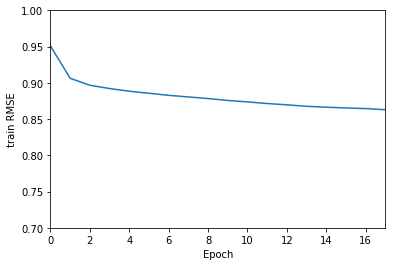

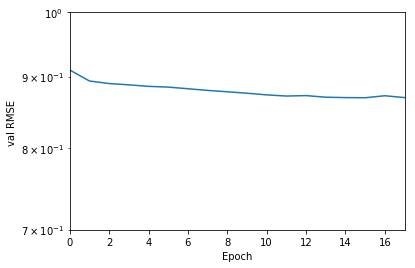

In [18]:
#plots..................................................................
pd.Series(history.history['loss']).plot(logy=False).set_ylim([0.7,1.0])
plt.xlabel("Epoch")
plt.ylabel(" train RMSE ")
plt.show()
pd.Series(history.history['val_loss']).plot(logy=True).set_ylim([0.7,1.0])
plt.xlabel("Epoch")
plt.ylabel("val RMSE ")
plt.show()


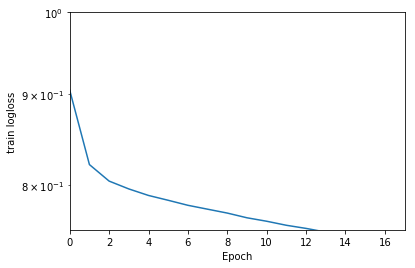

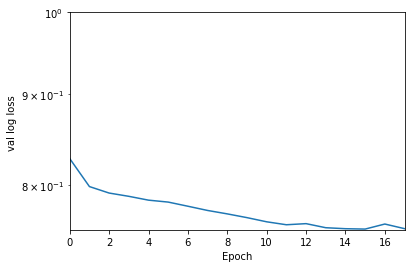

In [4]:
#plots..................................................................
pd.Series(loss['training']).plot(logy=True).set_ylim([0.755,1.0])
plt.xlabel("Epoch")
plt.ylabel(" train logloss ")
plt.show()
pd.Series(loss['validation']).plot(logy=True).set_ylim([0.755,1.0])
plt.xlabel("Epoch")
plt.ylabel("val log loss ")
plt.show()



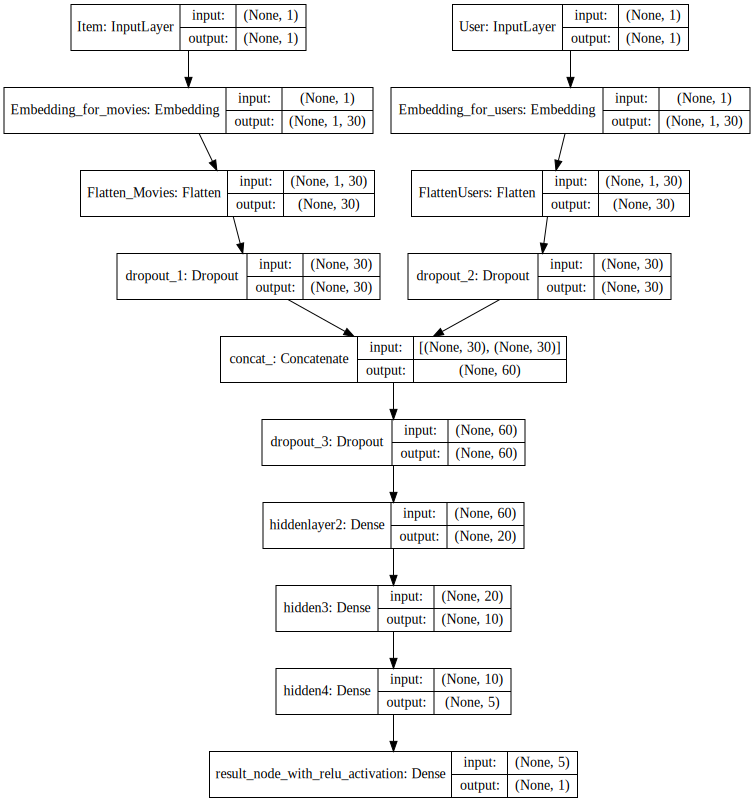

In [5]:
#architecture..................................................................
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [17]:
import pandas as pd
RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'
MODEL_WEIGHTS_FILE = 'ml1m_weights_0.h5'
K_FACTORS = 30
TEST_USER = 1#<-test user.....
top_k_ratings=10

ratings = pd.read_csv(RATINGS_CSV_FILE, sep='\t', encoding='latin-1', usecols=['userid', 'movieid', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print (len(ratings), 'ratings loaded.')

users = pd.read_csv(USERS_CSV_FILE, sep='\t', encoding='latin-1', usecols=['userid', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
print( len(users), 'descriptions of', max_userid, 'users loaded.')


movies = pd.read_csv(MOVIES_CSV_FILE, sep='\t', encoding='latin-1', usecols=['movieid', 'title', 'genre'])
print (len(movies), 'descriptions of', max_movieid, 'movies loaded.')

trained_model = Deep_networkModel(max_userid, max_movieid, K_FACTORS)

trained_model.load_weights(MODEL_WEIGHTS_FILE)
trained_model.summary()

users[users['userid'] == TEST_USER]
def predict_rating(userid, movieid):

      return trained_model.predict([np.array([userid]), np.array([movieid])])[0][0]

user_ratings = ratings[ratings['userid'] == TEST_USER][[ 'movieid']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movieid']), axis=1)

#Top K ratings for user..................................................................
user_ratings.sort_values(by='prediction', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(top_k_ratings)

1000209 ratings loaded.
6040 descriptions of 6040 users loaded.
3883 descriptions of 3952 movies loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Embedding_for_movies (Embedding (None, 1, 30)        118590      Item[0][0]                       
__________________________________________________________________________________________________
Embedding_for_users (Embedding) (None, 1, 30)        181230      User[0][0]                       
____

,movieid,prediction,title,genre
0,1197,4.454967,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
1,1035,4.301311,"Sound of Music, The (1965)",Musical
2,2018,4.298745,Bambi (1942),Animation|Children's
3,588,4.217417,Aladdin (1992),Animation|Children's|Comedy|Musical
4,919,4.076934,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
5,1207,4.062168,To Kill a Mockingbird (1962),Drama
6,1246,3.976522,Dead Poets Society (1989),Drama
7,1022,3.915877,Cinderella (1950),Animation|Children's|Musical
8,594,3.894730,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
9,1270,3.844824,Back to the Future (1985),Comedy|Sci-Fi


In [7]:
user_ratings.sort_values(by='prediction', 
                         ascending=False).merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(top_k_ratings).to_csv("user_ratings_prediction_top_10.csv", 
              sep='\t', 
              header=True)